# **Which US Democratic Presidential Nominee said this? Warren? Biden? Sanders?**
---
### *Text Classification of quotes from candidates vying to be the Democratic presidential nominee for the 2020 US presidential election.*
---

Here, all data has been extracted from debates between candidates. We will build a NLP classification model to identify who said what for a subset of unlabeled data.


The quotes are subjected to basic text-preprocessing steps such as
1. Stopword removal
2. Punctuation removal
3. Lemmatization
4. Tokenization using unigram

To prepare data for modeling, I performed feature engineering. Here, I engineered features which utilize count of various components of the text such as character, word, punctuation etc. 

The text classification is done using **Supervised & Semi-Supervised techniques.**

The following models were explored:
1. Regularized Logistic Regression
2. Random Forest
3. XGBoost


In [ ]:
import pandas as pd
import numpy as np
import re
from scipy.sparse import hstack
import string

from os import listdir
from os.path import isfile, join


import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import xgboost as xgb
import sklearn
from sklearn import model_selection, preprocessing
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn import decomposition, ensemble
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix 
from sklearn.metrics import accuracy_score 
from sklearn.metrics import classification_report 

from sklearn.ensemble import RandomForestClassifier

import nltk
from nltk.tokenize import WhitespaceTokenizer 
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer 

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
nltk.download("stopwords")
nltk.download("wordnet")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True



---



# Set up


---



#### 1. Load training and test dataset into dataframe

---

In [ ]:
base_path = 'drive/My Drive/Colab Notebooks/Data/'
def read_files(path):
  onlyfiles = [f for f in listdir(path) if isfile(join(path, f))]
  name_list, file_list = [], []
  print("Reading in ", len(onlyfiles), " files.")
  for f in onlyfiles:
    file = open(path + "/" + f, 'r')
    lines  = file.readlines()
    file_list.append(lines)
    name_list.append(f.split("_")[:2])
  print("Read ", len(name_list), " files.")
  return(name_list,file_list)

In [ ]:
#reading train data
train_path = base_path + "train"
names, file_content = read_files(train_path) 

Reading in  528  files.
Read  528  files.


In [ ]:
#convert to dataframe
#convert to data frame
train_all = pd.DataFrame(file_content, columns = ['c'])
split_data = train_all["c"].str.split(":")
#extract all names
c_name = []
c_quote = []
for s in split_data:
  c_name.append(s[0].split()[1].upper().replace("'", ""))
  c_quote.append(str(s[1:]))

train_df = pd.DataFrame({"label" : c_name, "Quotes": c_quote})

In [ ]:
train_df.head()

,label,Quotes
0,HARRIS,[' He was born… He has conducted foreign polic...
1,OROURKE,[' How else can we explain that we lose nearly...
2,HARRIS,[' Five million assault weapons are on the str...
3,BUTTIGIEG,"[' My response is, I completely agree, and I w..."
4,SANDERS,[' Second of all… Maybe you did that and made ...


In [ ]:
#reading test data
test_path = base_path + "test"
test_file, test_list = read_files(test_path)

Reading in  111  files.
Read  111  files.


In [ ]:
new_file = []
for f_ in test_file:
  new_file.append("_".join(f_))
#test_file

In [ ]:
test_df = pd.DataFrame({"file_name" : new_file,"Quotes": test_list})
test_df.head()

,file_name,Quotes
0,test_78.txt,"[Yeah, I think that we’re on the right track i..."
1,test_64.txt,[There are only two countries in the world tha...
2,test_96.txt,"[Sure, there’s one point we’re really missing ..."
3,test_94.txt,"[I’m not wedded to a particular solution, but ..."
4,test_3.txt,[There’s a larger battle going on on the plane...


In [ ]:
test_df['Quotes'] = test_df['Quotes'].apply(lambda x: ','.join(map(str, x)))
test_df.head()

,file_name,Quotes
0,test_78.txt,"Yeah, I think that we’re on the right track in..."
1,test_64.txt,There are only two countries in the world that...
2,test_96.txt,"Sure, there’s one point we’re really missing o..."
3,test_94.txt,"I’m not wedded to a particular solution, but I..."
4,test_3.txt,There’s a larger battle going on on the planet...


There are 528 training observations and 111 test observations

#### 2. Create a vector of training labels.

---

In [ ]:
#instances where the name of the file does not align with the name at the start of the text
count = 0
candidate_name = train_df.label
for i in range(len(names)):
  c = candidate_name[i].lower().strip()
  #print(names[i], c)
  if (names[i][0].lower().replace("'", "") != c):
    print(names[i][0], c)
    count += 1
print("There are", count, "mismatch in training files")

There are 0 mismatch in training files


There are no observations where the candidate name in the file name and in the file content don't match.


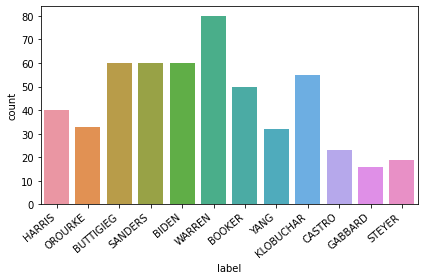

In [ ]:
#find training labels
ax = sns.countplot(x='label',data=train_df)

ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
plt.tight_layout()
plt.show()

We can see that distribution is around ~60 for 5 candidates and for the other 5 it is around ~30 counts. The lowest count is for Tulsi Gabbard and highest for Elizabeth Warren.

In [ ]:
class_names = train_df.label.unique()
print("There are", len(class_names), "candidates.\nThey are as follows:", class_names)
#creating a vector of labels
# label encode the target variable 
train_y = train_df.label
encoder = preprocessing.LabelEncoder()
train_y_vector = encoder.fit_transform(train_y)
print(train_y_vector)

There are 12 candidates.
They are as follows: ['HARRIS' 'OROURKE' 'BUTTIGIEG' 'SANDERS' 'BIDEN' 'WARREN' 'BOOKER' 'YANG'
 'KLOBUCHAR' 'CASTRO' 'GABBARD' 'STEYER']
[ 5  7  5  2  8  7  2  8  5  0 10  0  5 10  1  8 10  7  8  2  0 11  0  6
 10  6 10  7  5  0 10 11  8  5  1  7 10  6  8 11 10  7  1 10 10  0  5  2
  6  0 11  2 10  6  6  2  5  5  7  1 10  7  6  7  2 10  5  2 10 10  6  5
  6 10 11  5  8  2  8  8 10  6 10 10 10  8  2 10  8  3  1  0 10  7 11  6
  1  0  1 11  6  8  0  7 10  5  8  5  5  2  0 11  1  1 10  1  5  3  8  7
  7  8  3  6 10  1  2  3 10  5  7  1  2 10  6  1  0  6  5 10 10 10  1  6
  1  3 10 10  8  2  2  2 10  1  7  8  6  5 10 11  2  6  7 11  0  3  1 11
  5  5  7  8 10  2 10  8  0 10  0  6  8  8 10 11  5  8  0 11  0  8  7  5
  2  1  0  8  3  6  1  5 10  1  0 10 10 11  8  1  8  2  6  7  6 10  1 10
 11  0 11  0  7  8  8  3  8  0  8  5  6 10  6  6 10  3  7  0  8  0  7  8
  6 10  6  5  3  6  6  1  0  8  8  1  8  6  3  6  8  6  2 11  6  2 10 11
  5 10  5  3  2 10  7  7 10  6  5 

#### 3. Remove stopwords & punctuations

---

In [ ]:
#to find custom stopwords
count_words = train_df.Quotes.str.split(expand=True).stack().value_counts(normalize=True).mul(100).round(3)
for ix, c in count_words[:50].items():
  print(ix, c)


the 4.265
to 3.491
and 2.513
of 2.185
that 2.178
a 1.963
I 1.913
in 1.878
we 1.592
is 1.463
have 1.113
for 1.018
this 0.958
[' 0.807
on 0.776
And 0.698
our 0.69
it 0.684
are 0.673
not 0.643
you 0.608
people 0.595
with 0.585
what 0.56
be 0.552
about 0.511
who 0.451
do 0.451
We 0.439
they 0.424
was 0.416
will 0.415
going 0.384
as 0.375
my 0.361
has 0.358
all 0.32
get 0.32
but 0.318
at 0.318
can 0.309
when 0.305
from 0.297
think 0.289
because 0.286
their 0.283
need 0.283
up 0.28
by 0.279
he 0.271


Here after finding the frequency of the words in the quotes, we notice that amongst the general stopwords of english languages other words such as - United, States, America, American, People appear too. It is obvious that candidates vying for the ticker will be using these words in their speeches and hence can be added to the stopwords list

In [ ]:
my_stopwords = nltk.corpus.stopwords.words('english')
my_stopwords.extend(["america", "american", "united", "people"])
my_punctuation = '!"$%&\'()*+,-.…/:;<=>?[\\]^_`{|}~•@’'
def cleanQuotes(quote):
  #print(quote)
  quote = quote.lower() # lower case
  #print(quote)
  quote = quote.strip()#remove double spacing
  #quote_new = quote.translate(str.maketrans(dict.fromkeys(string.punctuation)))  
  quote = "".join([char.lower() for char in quote if char not in my_punctuation]) 
  quote = re.sub('['+my_punctuation + ']+', ' ', quote) # strip punctuation
  quote = " ".join([word for word in quote.split(' ') if word not in my_stopwords])
  return quote.strip()

In [ ]:
train_df['clean_quote'] = train_df.Quotes.apply(cleanQuotes)

In [ ]:
train_df.head()

,label,Quotes,clean_quote
0,HARRIS,[' He was born… He has conducted foreign polic...,born conducted foreign policy since day one bo...
1,OROURKE,[' How else can we explain that we lose nearly...,else explain lose nearly 40000 country gun vio...
2,HARRIS,[' Five million assault weapons are on the str...,five million assault weapons streets today cou...
3,BUTTIGIEG,"[' My response is, I completely agree, and I w...",response completely agree welcome challenge co...
4,SANDERS,[' Second of all… Maybe you did that and made ...,second maybe made money healthcare job run non...


#### 4. Stem/lemmatize your training data using a stemmer/lemmatizer of your choosing

---

Stem/lemmatize your training data using a stemmer/lemmatizer of your choosing. Show a before and after using a few observations and comment on what you see.

In [ ]:
lemmatizer = WordNetLemmatizer() 
tk = WhitespaceTokenizer() 
def lemmatizeQuotes(quote):
  quote = " ".join([lemmatizer.lemmatize(word) for word in tk.tokenize(quote)])
  return(quote)

In [ ]:
train_df["final_clean"] = train_df.clean_quote.apply(lambda x: lemmatizeQuotes(x))

In [ ]:
train_df.head()

,label,Quotes,clean_quote,final_clean
0,HARRIS,[' He was born… He has conducted foreign polic...,born conducted foreign policy since day one bo...,born conducted foreign policy since day one bo...
1,OROURKE,[' How else can we explain that we lose nearly...,else explain lose nearly 40000 country gun vio...,else explain lose nearly 40000 country gun vio...
2,HARRIS,[' Five million assault weapons are on the str...,five million assault weapons streets today cou...,five million assault weapon street today cours...
3,BUTTIGIEG,"[' My response is, I completely agree, and I w...",response completely agree welcome challenge co...,response completely agree welcome challenge co...
4,SANDERS,[' Second of all… Maybe you did that and made ...,second maybe made money healthcare job run non...,second maybe made money healthcare job run non...


In [ ]:
for i in range(3):
  print("The text\n",train_df.iloc[i, 2])
  print("After lemmatization\n",train_df.iloc[i, 3])

The text
 born conducted foreign policy since day one born fragile ego fails understand one important responsibilities commanderinchief concern security nation homeland way understands part strength nation therefore extension ability secure vibrant military walk room around globe respected keep word consistent speak truth loyal donald trump done pulling paris agreement pulling iran nuclear deal consistently turning back stood us difficult times including recently kurds points donald trump greatest threat national security nation moment
After lemmatization
 born conducted foreign policy since day one born fragile ego fails understand one important responsibility commanderinchief concern security nation homeland way understands part strength nation therefore extension ability secure vibrant military walk room around globe respected keep word consistent speak truth loyal donald trump done pulling paris agreement pulling iran nuclear deal consistently turning back stood u difficult time in

As is observed from the texts, plurals such as mothers, victims are converted to mother, victim. I chose lemmatization as it generates valid lemma.

#### 5. Tokenize your training data using unigrams

---

Tokenize your training data using unigrams (hint: see sklearn’s CountVectorizer). If you set upper and lower limits on word frequency, what are they? How many unique tokens are in your vocabulary?

In [ ]:
vectorizer = CountVectorizer(max_df=0.95, min_df=13, ngram_range=(1, 1))
# apply transformation
train_x = vectorizer.fit_transform(train_df['final_clean'])
tf_feature_names = vectorizer.get_feature_names()
print("There are ", len(tf_feature_names), "unique tokens in our vocabulary")

There are  432 unique tokens in our vocabulary


Here, I have used a max_df of 0.95 to ignore words which occur in more than 95% of documents and min_df 13 to eliminate those which occur in less than 13 documents as there were no candidates with less than 13 quotes.

#### 6. Process the test data in a manner identical to the training data.

---

In [ ]:
test_x = vectorizer.transform(test_df.Quotes)

In [ ]:
print("The number of feature in training is", train_x.shape[1], "and in test is" ,test_x.shape[1])

The number of feature in training is 432 and in test is 432


Therefore, the number of features for your training and test data are identical.

---
# Supervised Learning
---

#### 7. Feature Engineering


---

Here, I engineered features which utilize count of various components of the text such as character, word, punctuation etc. 

In [ ]:
train_df['char_count'] = train_df['Quotes'].apply(len)
train_df['word_count'] = train_df['Quotes'].apply(lambda x: len(x.split()))
train_df['word_density'] = train_df['char_count']/(train_df['word_count'] + 1)
train_df['punctuation_count'] = train_df['Quotes'].apply(lambda x: len("".join(_ for _ in x if _ in string.punctuation))) 
train_df['title_word_count'] = train_df['Quotes'].apply(lambda x: len([word for word in x.split() if word.istitle()]))
train_df['upper_case_word_count'] = train_df['Quotes'].apply(lambda x: len([word for word in x.split() if word.isupper()]))


In [ ]:
test_df['char_count'] = test_df['Quotes'].apply(len)
test_df['word_count'] = test_df['Quotes'].apply(lambda x: len(x.split()))
test_df['word_density'] = test_df['char_count']/(test_df['word_count']+1)
test_df['punctuation_count'] = test_df['Quotes'].apply(lambda x: len("".join(_ for _ in x if _ in string.punctuation))) 
test_df['title_word_count'] = test_df['Quotes'].apply(lambda x: len([word for word in x.split() if word.istitle()]))
test_df['upper_case_word_count'] = test_df['Quotes'].apply(lambda x: len([word for word in x.split() if word.isupper()]))


In [ ]:
num_features = [f_ for f_ in train_df.columns\
                if f_ in ["char_count", "word_count", "word_density", 'punctuation_count','title_word_count', 'upper_case_word_count']]

for f in num_features:
    all_cut = pd.cut(pd.concat([train_df[f], test_df[f]], axis=0), bins=20, labels=False, retbins=False)
    train_df[f] = all_cut.values[:train_df.shape[0]]
    test_df[f] = all_cut.values[train_df.shape[0]:]

train_num_features = train_df[num_features].values
test_num_features = test_df[num_features].values

In [ ]:
train_features = hstack([train_x, train_num_features]) 
test_features = hstack([test_x, test_num_features])

In [ ]:
print("The number of features in train set", train_features.shape[1])
print("The number of features in test set", test_features.shape[1])

The number of features in train set 438
The number of features in test set 438


Thus, the number of features remain identical after adding 6 more features. These features were added to the countVectorizer generated features.

#### 8. Regularized Logistic Regression Model

---

Here I have used L1 regulaization for the losgistic regression model. 

In [ ]:
clf_rl = LogisticRegression(penalty="l1", solver='liblinear')
clf_rl.fit(train_features,train_y)
print("For the regularized logistic regression, the coefficents are as follows:\n")
print(clf_rl.coef_)

For the regularized logistic regression, the coefficents are as follows:

[[ 0.          0.          0.         ...  0.31791381  0.16142344
  -0.09281191]
 [ 0.          0.          0.         ... -0.14105083 -0.05026256
  -0.12746043]
 [ 0.          0.          0.452483   ... -0.41088216 -0.13892871
  -0.03996163]
 ...
 [ 0.          0.          0.         ... -0.43695904  0.
  -0.19559368]
 [ 0.          0.          0.         ...  0.         -0.10927211
   0.06460022]
 [ 0.          0.          0.         ... -0.04604217 -0.02667437
  -0.14576445]]


In [ ]:
print("The training accuracy score is", clf_rl.score(train_features, train_y)*100, "%")

The training accuracy score is 96.96969696969697 %


The model performs exceptionally well in terms of accuracy. Now, lets explore class-specific metrics.

In [ ]:
rl_report = classification_report(train_y, clf_rl.predict(train_features))

matrix = confusion_matrix(train_y, clf_rl.predict(train_features), labels = class_names)
rl_acc = matrix.diagonal()/matrix.sum(axis=1 )
c1_df = pd.DataFrame({'accuracy': rl_acc}, index=class_names)
cm1_df = pd.DataFrame(matrix, index = class_names, columns = class_names)

print(rl_report)
print("=========================================================\n\n\nThe accuracy for each class is\n\n\n", c1_df)
print("=========================================================\n\n\nConfusion Matrix\n\n")
cm1_df.head(12)

              precision    recall  f1-score   support

       BIDEN       0.97      0.97      0.97        60
      BOOKER       0.98      0.94      0.96        50
   BUTTIGIEG       0.95      1.00      0.98        60
      CASTRO       0.95      0.91      0.93        23
     GABBARD       1.00      1.00      1.00        16
      HARRIS       0.97      0.97      0.97        40
   KLOBUCHAR       1.00      0.98      0.99        55
     OROURKE       1.00      1.00      1.00        33
     SANDERS       0.98      1.00      0.99        60
      STEYER       1.00      1.00      1.00        19
      WARREN       0.92      0.97      0.95        80
        YANG       1.00      0.84      0.92        32

    accuracy                           0.97       528
   macro avg       0.98      0.97      0.97       528
weighted avg       0.97      0.97      0.97       528



The accuracy for each class is


            accuracy
HARRIS     0.975000
OROURKE    1.000000
BUTTIGIEG  1.000000
SANDERS    1.0000

,HARRIS,OROURKE,BUTTIGIEG,SANDERS,BIDEN,WARREN,BOOKER,YANG,KLOBUCHAR,CASTRO,GABBARD,STEYER
HARRIS,39,0,1,0,0,0,0,0,0,0,0,0
OROURKE,0,33,0,0,0,0,0,0,0,0,0,0
BUTTIGIEG,0,0,60,0,0,0,0,0,0,0,0,0
SANDERS,0,0,0,60,0,0,0,0,0,0,0,0
BIDEN,0,0,0,0,58,1,1,0,0,0,0,0
WARREN,0,0,0,0,1,78,0,0,0,1,0,0
BOOKER,1,0,0,0,1,1,47,0,0,0,0,0
YANG,0,0,1,1,0,3,0,27,0,0,0,0
KLOBUCHAR,0,0,0,0,0,1,0,0,54,0,0,0
CASTRO,0,0,1,0,0,1,0,0,0,21,0,0


As is made obvious from the confusion metrics, there are very few misclassified data points. From observing the accuracy and confusion matrix, we know that the candidate - YANG has the most misclassified quotes with a count of 5 and accuracy of 0.843. Thus, here the performance of the model is not as good as other classes where there are no to 2 misclassified points. It is also worth noting that the classifier has 100% accuracy for classes GABBARD, SANDER, BUTTIGIEG, OROURKE, STEYER alongwith almost perfect precision, recall and f1- score in some of these classes.

#### 9. Tree-based Model

---

Here, I'm using a random forest model as there ensemble component will help idenitfy good split criteria. It also decorrelates tree though at the expense of interpretability.

In [ ]:
clf_rf = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=100, max_leaf_nodes=None, min_impurity_split=None,
            min_samples_leaf=3, min_samples_split=10, n_estimators=10, random_state=None)

clf_rf.fit(train_features,train_y)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=100, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=3, min_samples_split=10,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [ ]:
print("The training accuracy score is", clf_rf.score(train_features, train_y)*100, "%")

The training accuracy score is 81.25 %


In [ ]:
rf_report = classification_report(train_y, clf_rf.predict(train_features))

matrix = confusion_matrix(train_y, clf_rf.predict(train_features), labels = class_names)
rf_acc = matrix.diagonal()/matrix.sum(axis=1 )
c2_df = pd.DataFrame({'accuracy': rf_acc}, index=class_names)
cm2_df = pd.DataFrame(matrix, index = class_names, columns = class_names)

print(rf_report)
print("=========================================================\n\n\nThe accuracy for each class is\n\n\n", c2_df)
print("=========================================================\n\n\nConfusion Matrix\n\n")
cm2_df.head(12)

              precision    recall  f1-score   support

       BIDEN       0.82      0.85      0.84        60
      BOOKER       0.77      0.80      0.78        50
   BUTTIGIEG       0.84      0.87      0.85        60
      CASTRO       1.00      0.65      0.79        23
     GABBARD       1.00      0.62      0.77        16
      HARRIS       0.87      0.82      0.85        40
   KLOBUCHAR       0.81      0.78      0.80        55
     OROURKE       1.00      0.70      0.82        33
     SANDERS       0.81      0.97      0.88        60
      STEYER       1.00      0.63      0.77        19
      WARREN       0.68      0.93      0.78        80
        YANG       0.90      0.56      0.69        32

    accuracy                           0.81       528
   macro avg       0.87      0.77      0.80       528
weighted avg       0.83      0.81      0.81       528



The accuracy for each class is


            accuracy
HARRIS     0.825000
OROURKE    0.696970
BUTTIGIEG  0.866667
SANDERS    0.9666

,HARRIS,OROURKE,BUTTIGIEG,SANDERS,BIDEN,WARREN,BOOKER,YANG,KLOBUCHAR,CASTRO,GABBARD,STEYER
HARRIS,33,0,0,1,1,2,1,0,2,0,0,0
OROURKE,0,23,3,1,1,2,2,1,0,0,0,0
BUTTIGIEG,1,0,52,1,1,5,0,0,0,0,0,0
SANDERS,0,0,0,58,2,0,0,0,0,0,0,0
BIDEN,1,0,1,1,51,3,2,0,1,0,0,0
WARREN,0,0,0,2,1,74,1,1,1,0,0,0
BOOKER,0,0,2,1,2,3,40,0,2,0,0,0
YANG,1,0,1,1,1,9,1,18,0,0,0,0
KLOBUCHAR,1,0,2,1,0,7,1,0,43,0,0,0
CASTRO,0,0,1,1,1,1,1,0,3,15,0,0


As is made obvious from the confusion matrix, there are more misclassified data points than the previous model. From observing the accuracy and confusion matrix, we know that the candidate - YANG has the most misclassified quotes with accuracy of 0.375. Thus, here the performance of the model for this class is worse than the previous model. Even for other classes the accuracy is lower with highest accuracy for BIDEN, WARREN, SANDERS with good f1 scores too.

#### 10. Pick your own model

---

The model of my choice is Gradient Boosted Decision Tree which I have implemented using python's XGBoost library. I have read a lot about it and have seen it becoming a winner algo in several Kaggle competition. To tune the parameters I used a grid search to tune the depth, estimators.

In [ ]:
m_xgb = xgb.XGBClassifier(objective='binary:logistic',booster = "gbtree", eval_metric='auc')
clf_xgb = model_selection.GridSearchCV(m_xgb,{'max_depth': [4,6, 8],'n_estimators': [50,100,200]})

In [ ]:
clf_xgb.fit(train_features,train_y)
print("The best score", clf_xgb.best_score_)

The best score 0.38061096136567835


In [ ]:
print("The training accuracy score is", clf_xgb.score(train_features, train_y)*100, "%")

The training accuracy score is 100.0 %


In [ ]:
xg_report = classification_report(train_y, clf_xgb.predict(train_features))

matrix = confusion_matrix(train_y, clf_xgb.predict(train_features), labels = class_names)
xg_acc = matrix.diagonal()/matrix.sum(axis=1 )
c3_df = pd.DataFrame({'accuracy': xg_acc}, index=class_names)
cm3_df = pd.DataFrame(matrix, index = class_names, columns = class_names)

print(xg_report)
print("=========================================================\n\n\nThe accuracy for each class is\n\n\n", c3_df)
print("=========================================================\n\n\nConfusion Matrix\n\n")
cm3_df.head(12)

              precision    recall  f1-score   support

       BIDEN       1.00      1.00      1.00        60
      BOOKER       1.00      1.00      1.00        50
   BUTTIGIEG       1.00      1.00      1.00        60
      CASTRO       1.00      1.00      1.00        23
     GABBARD       1.00      1.00      1.00        16
      HARRIS       1.00      1.00      1.00        40
   KLOBUCHAR       1.00      1.00      1.00        55
     OROURKE       1.00      1.00      1.00        33
     SANDERS       1.00      1.00      1.00        60
      STEYER       1.00      1.00      1.00        19
      WARREN       1.00      1.00      1.00        80
        YANG       1.00      1.00      1.00        32

    accuracy                           1.00       528
   macro avg       1.00      1.00      1.00       528
weighted avg       1.00      1.00      1.00       528



The accuracy for each class is


            accuracy
HARRIS          1.0
OROURKE         1.0
BUTTIGIEG       1.0
SANDERS         1

,HARRIS,OROURKE,BUTTIGIEG,SANDERS,BIDEN,WARREN,BOOKER,YANG,KLOBUCHAR,CASTRO,GABBARD,STEYER
HARRIS,40,0,0,0,0,0,0,0,0,0,0,0
OROURKE,0,33,0,0,0,0,0,0,0,0,0,0
BUTTIGIEG,0,0,60,0,0,0,0,0,0,0,0,0
SANDERS,0,0,0,60,0,0,0,0,0,0,0,0
BIDEN,0,0,0,0,60,0,0,0,0,0,0,0
WARREN,0,0,0,0,0,80,0,0,0,0,0,0
BOOKER,0,0,0,0,0,0,50,0,0,0,0,0
YANG,0,0,0,0,0,0,0,32,0,0,0,0
KLOBUCHAR,0,0,0,0,0,0,0,0,55,0,0,0
CASTRO,0,0,0,0,0,0,0,0,0,23,0,0


As is made obvious from the confusion matrix, there are no misclassified data points. This might be due to overfitting. 

#### 11. Compare the performance of the three classifiers you built

---

In my opinion, the best classifier in terms of accuracy, precision, and time is regularized logistic regression. While XGBoost has a perfect score on all evaluation metric, I'm worried it might be overfitting to the training data. In addition to this, it takes 2.5 - 3 mins to train. Thus, if I were to rank the performance only on the quantitative values while ignoring other potential issues, the ranking is - XGBoost, Reguliarized Logistic Regression, Random Forest.

However, as mentioned before I'm a bit hesistant about the perfect score of XGBoost as this might be potentially due to overfitting resulting in poor performance on the test data. Additionally, it takes 2.5- 3 min to train as compared to a few seconds taken by the other two models. Thus, the best classifier ranked then is Regularized Logistic Regression, XGBoost, Random Forest. Random Forest gives poorer metric score and it is acceptable to spend more time on XGBoost to get better result.

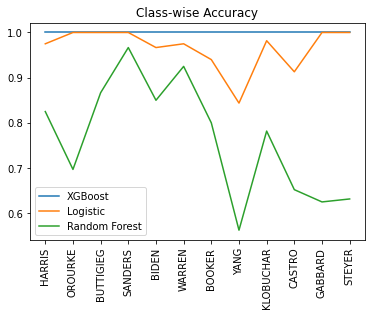

In [ ]:
#create graph comparing accuracy and f1 score accross different class.
x = class_names
plt.plot(c3_df.index, c3_df.accuracy)
plt.plot(c1_df.index, c1_df.accuracy)
plt.plot(c2_df.index, c2_df.accuracy)

plt.title("Class-wise Accuracy")
plt.legend(['XGBoost', 'Logistic', 'Random Forest'], loc='lower left')
plt.xticks(rotation=90)
plt.show()


It is obvious from the graph that while logistic regression approaches the apparent state of the art / overfitted solution of XGBoost for some classes, it also performs significantly well in those classes where random forest has almost 50% accuracy. This shows that it is doing a good job at learning features and fitting to the training data while ignoring noises and thus, should retain this while dealing with unseen test dataset.

#### 12. Generate labels

---

Here, I'm using the regularized logistic regression model to generate labels


In [ ]:
#generate labels
part_2_labels = clf_rl.predict(test_features)
print(part_2_labels)

['BUTTIGIEG' 'YANG' 'STEYER' 'BUTTIGIEG' 'GABBARD' 'BUTTIGIEG' 'WARREN'
 'SANDERS' 'GABBARD' 'BUTTIGIEG' 'BOOKER' 'BUTTIGIEG' 'GABBARD'
 'BUTTIGIEG' 'KLOBUCHAR' 'WARREN' 'YANG' 'SANDERS' 'BUTTIGIEG' 'YANG'
 'WARREN' 'BOOKER' 'BUTTIGIEG' 'BIDEN' 'HARRIS' 'SANDERS' 'OROURKE'
 'HARRIS' 'YANG' 'GABBARD' 'HARRIS' 'STEYER' 'GABBARD' 'SANDERS' 'WARREN'
 'BUTTIGIEG' 'WARREN' 'OROURKE' 'BOOKER' 'WARREN' 'WARREN' 'YANG'
 'KLOBUCHAR' 'BUTTIGIEG' 'BOOKER' 'HARRIS' 'BIDEN' 'SANDERS' 'WARREN'
 'KLOBUCHAR' 'BUTTIGIEG' 'YANG' 'KLOBUCHAR' 'BIDEN' 'KLOBUCHAR'
 'KLOBUCHAR' 'KLOBUCHAR' 'SANDERS' 'WARREN' 'CASTRO' 'WARREN' 'KLOBUCHAR'
 'BUTTIGIEG' 'OROURKE' 'WARREN' 'BUTTIGIEG' 'KLOBUCHAR' 'OROURKE'
 'BUTTIGIEG' 'WARREN' 'HARRIS' 'OROURKE' 'BUTTIGIEG' 'BIDEN' 'SANDERS'
 'BUTTIGIEG' 'WARREN' 'SANDERS' 'YANG' 'BOOKER' 'WARREN' 'BUTTIGIEG'
 'SANDERS' 'BIDEN' 'SANDERS' 'STEYER' 'KLOBUCHAR' 'OROURKE' 'BOOKER'
 'KLOBUCHAR' 'BUTTIGIEG' 'BIDEN' 'BIDEN' 'BOOKER' 'BUTTIGIEG' 'WARREN'
 'YANG' 'WARREN' 'WARREN' 'BOOKE

---
# Semi-Supervised Learning

---



#### 13. Pick Model

---

The model of my choice is the regularized logistic regression model as it performed exceptionally well in terms of accuracy, precision, recall, f1-score and time. 

In [ ]:
clf_semi = sklearn.base.clone(clf_rl, safe=True)

#### 14. First iteration

---

In [ ]:
#fit to un edited train data 
clf_semi.fit(train_features,train_y)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l1',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

In [ ]:
print("The accuracy of the model before iteration on the original train data is" ,clf_semi.score(train_features,train_y) * 100, "%" )

The accuracy of the model before iteration on the original train data is 96.96969696969697 %


In [ ]:
#create duplicates of train and test data frame to edit 
dup_train = train_df
#dup_train.tail(20)
dup_test = test_df    
dup_test.head()

,file_name,Quotes,char_count,word_count,word_density,punctuation_count,title_word_count,upper_case_word_count
0,test_78.txt,"Yeah, I think that we’re on the right track in...",7,7,9,7,3,3
1,test_64.txt,There are only two countries in the world that...,14,14,8,12,7,2
2,test_96.txt,"Sure, there’s one point we’re really missing o...",16,15,9,11,14,0
3,test_94.txt,"I’m not wedded to a particular solution, but I...",0,0,9,0,1,1
4,test_3.txt,There’s a larger battle going on on the planet...,5,5,11,4,4,1


Creating function to get top 11 instances of the predicted labels and to move row from test to train data

In [ ]:
#get top instances 
def getTopInstances(test, testFeature, total):
  prob_predicted = {}
  k = 0
  for i, row in test.iterrows():
    prob_dict = dict(zip(clf_semi.classes_, clf_semi.predict_proba(testFeature)[k]))
    results = list(map(lambda x: (x[0], x[1]), sorted(zip(clf_semi.classes_, clf_semi.predict_proba(testFeature)[k]), key=lambda x: x[1], reverse=True)))
    prob_predicted[i] = results[0]
    k += 1
  print("The class and their associated probability", prob_predicted)
  sort_prob = sorted(prob_predicted.keys(), key=lambda x: prob_predicted[x][1], reverse=True)[:total]
  return(sort_prob, prob_predicted)

In [ ]:
#get top 10 index and classes
def addTopTest(test, train, prob_class, prob_pred):
  #find label class and index to add
  k = 1
  l = 11
  for i in prob_class:
    curr_row = []
    #remove from the test features
    curr_s= test.loc[[i]]
    #drop these rows from the data frame
    test = test.drop([i])
    clean = cleanQuotes(curr_s.Quotes.item())
    final_clean = lemmatizeQuotes(clean)
    curr_row.append([prob_pred[i][0], curr_s.Quotes.item(), clean, final_clean, curr_s.char_count.item(), curr_s.word_count.item(), curr_s.word_density.item(),\
                     curr_s.punctuation_count.item(), curr_s.title_word_count.item(), curr_s.upper_case_word_count.item()])
    #add curr_row to training df
    train = train.append(pd.DataFrame(curr_row, columns = train.columns))
    print("Adding row ",i, " ----- ", k, "/", l)
    k += 1
    #print("Adding row\n",curr_row)
    #print("\nShape after adding row", train.shape)
  return(train, test)


In [ ]:
pc, pp = getTopInstances(dup_test, test_features, 11)

The class and their associated probability {0: ('BUTTIGIEG', 0.7544077826360094), 1: ('YANG', 0.46918590737837257), 2: ('STEYER', 0.37798623173465984), 3: ('BUTTIGIEG', 0.287684393177938), 4: ('GABBARD', 0.31403338198006103), 5: ('BUTTIGIEG', 0.5138170881762653), 6: ('WARREN', 0.3976050715524329), 7: ('SANDERS', 0.43015365352190665), 8: ('GABBARD', 0.5181363258244225), 9: ('BUTTIGIEG', 0.40003449674772407), 10: ('BOOKER', 0.7347451102795245), 11: ('BUTTIGIEG', 0.7684996809736496), 12: ('GABBARD', 0.6342615284364211), 13: ('BUTTIGIEG', 0.8818786647200211), 14: ('KLOBUCHAR', 0.5122780545439825), 15: ('WARREN', 0.43394211598820437), 16: ('YANG', 0.7740093314386182), 17: ('SANDERS', 0.32054577481059754), 18: ('BUTTIGIEG', 0.3351205071466052), 19: ('YANG', 0.25276003153668297), 20: ('WARREN', 0.7311497270790818), 21: ('BOOKER', 0.40578256573548105), 22: ('BUTTIGIEG', 0.39972289314746695), 23: ('BIDEN', 0.6736513068972034), 24: ('HARRIS', 0.7034310204650062), 25: ('SANDERS', 0.48330900764530

In [ ]:
#generate new train and test
dup_train, dup_test = addTopTest(dup_test, dup_train, pc, pp)

Adding row  38  -----  1 / 11
Adding row  92  -----  2 / 11
Adding row  91  -----  3 / 11
Adding row  13  -----  4 / 11
Adding row  100  -----  5 / 11
Adding row  52  -----  6 / 11
Adding row  44  -----  7 / 11
Adding row  30  -----  8 / 11
Adding row  16  -----  9 / 11
Adding row  11  -----  10 / 11
Adding row  0  -----  11 / 11


In [ ]:
print("The shape of train:", dup_train.shape, "\ntest:", dup_test.shape)

The shape of train: (539, 10) 
test: (100, 8)


In [ ]:
#vectorize and then 
#vectorize train and test both 
def generateFeatures(train, test):
  semi_train_x = vectorizer.transform(train['final_clean'])
  semi_test_x = vectorizer.transform(test.Quotes)
  semi_features = [f_ for f_ in train.columns\
                  if f_ in ["char_count", "word_count", "word_density", 'punctuation_count','title_word_count', 'upper_case_word_count']]
  print("The shape of train:", semi_train_x.shape, "\ntest:", semi_train_x .shape)


  for f in semi_features:
      all_cut = pd.cut(pd.concat([train[f], test[f]], axis=0), bins=20, labels=False, retbins=False)
      train[f] = all_cut.values[:train.shape[0]]
      test[f] = all_cut.values[train.shape[0]:]

  train_dup_features = train[semi_features].values
  test_dup_features = test[semi_features].values
  dup_train_features = hstack([semi_train_x, train_dup_features]) 
  dup_test_features = hstack([semi_test_x, test_dup_features])

  return(dup_train_features, dup_test_features)

In [ ]:
#generate feature for new test train
curr_train_feature, curr_test_feature = generateFeatures(dup_train, dup_test)

The shape of train: (539, 432) 
test: (539, 432)


In [ ]:
clf_semi.fit(curr_train_feature,dup_train.label)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l1',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

In [ ]:
accuracy = []
ac = clf_semi.score(train_features, train_df.label)
accuracy.append(ac)
print("The accuracy of the model after 1st iteration on the updated train data is" , clf_semi.score(curr_train_feature, dup_train.label) * 100, "%" )
print("The accuracy of the model after 1st iteration on the original train data is" ,ac * 100, "%" )

The accuracy of the model after 1st iteration on the updated train data is 97.21706864564007 %
The accuracy of the model after 1st iteration on the original train data is 97.1590909090909 %


The accuracy of the model for the original train data is 97.15% which is an increase from 96.96% which observed in part 2 or at the start of part 3.

#### 15. 9 more iteration and plotting performance in terms of accuracy

---

15. Now, repeat the process above 9 more times, each time adding an additional 10% of the test data for which the labels have the highest probability (note that this may result in different test observations being included from one iteration to the next). After each iteration, note the performance on the original training data set. Generate a plot which shows the percentage of the test dataset used on the X-axis and the classification accuracy on the original training dataset on the Y-axis. There should be 11 points for this plot, ranging from X = 0% to X = 100%, inclusive. What does the plot look like? Comment on what you see. (Note: this type of semi-supervised learning can very much be hit-or-miss. This type of learning doesn’t always yield benefits).


In [ ]:
for ix in range(2, 11):
  print("===============================" , ix, "===================================")
  if ix == 10:
    pc, pp = getTopInstances(dup_test, curr_test_feature, 12)
  else:
    pc, pp = getTopInstances(dup_test, curr_test_feature, 11)
  #generate new train and test
  dup_train, dup_test = addTopTest(dup_test, dup_train, pc, pp)
  print("The shape of train:", dup_train.shape, "\ntest:", dup_test.shape)
  #generate feature for new test train
  curr_train_feature, curr_test_feature = generateFeatures(dup_train, dup_test)
  clf_semi.fit(curr_train_feature,dup_train.label)
  ac = clf_semi.score(train_features, train_df.label)
  accuracy.append(ac)
  print("The accuracy of the model after", ix," iteration on the update train data is" , clf_semi.score(curr_train_feature, dup_train.label) * 100, "%" )
  print("The accuracy of the model after", ix,"iteration on the original train data is" ,ac * 100, "%" )
  

=============================== 2 ===================================
The class and their associated probability {1: ('HARRIS', 0.5370140363637693), 2: ('STEYER', 0.3609973954720476), 3: ('BUTTIGIEG', 0.26109378674812117), 4: ('GABBARD', 0.31323626908301777), 5: ('BUTTIGIEG', 0.5630621011811736), 6: ('WARREN', 0.4029957904999807), 7: ('SANDERS', 0.40985015405753555), 8: ('GABBARD', 0.539144963441624), 9: ('BUTTIGIEG', 0.38860779273557555), 10: ('BOOKER', 0.743482491689109), 12: ('GABBARD', 0.6600611921155172), 14: ('KLOBUCHAR', 0.5288514316303533), 15: ('WARREN', 0.4530261530430109), 17: ('SANDERS', 0.2896144325127799), 18: ('SANDERS', 0.22473656016250645), 19: ('YANG', 0.3172596733196375), 20: ('WARREN', 0.7336472555614226), 21: ('BOOKER', 0.3968275081500908), 22: ('BUTTIGIEG', 0.42344182574260775), 23: ('BIDEN', 0.6668716120662769), 24: ('HARRIS', 0.6059779887722132), 25: ('SANDERS', 0.4992663218357219), 26: ('OROURKE', 0.49002236599174126), 27: ('HARRIS', 0.35758147625509457), 28: (

In [ ]:
print(len(accuracy))

10


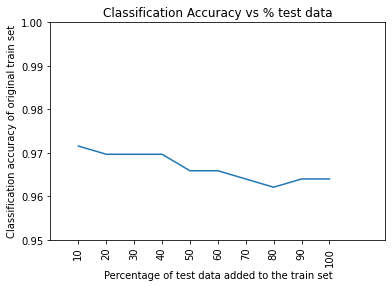

In [ ]:
plt.axes()
plt.plot(np.arange(10, 110, 10), accuracy)
plt.xlim([0, 120])
plt.ylim([0.95, 1])
plt.yticks(np.arange(0.95, 1, 0.01))
plt.xticks(np.arange(10, 110, 10))

plt.title("Classification Accuracy vs % test data")

plt.xticks(rotation=90)
plt.xlabel("Percentage of test data added to the train set")
plt.ylabel("Classification accuracy of original train set")
plt.show()
plt.show()

As we keep adding self-labelled test data to the training data and train on this new data, we notice that the accuracy for the original train data which initially now follows a decrease followed by increase pattern. Towards the end, the accuracy of the model for the original train data is a little less than the original regularized logistic regression model


#### 16. Generate labels for semi-supervised

---

In [ ]:
part_3_labels = clf_semi.predict(test_features)
print(part_3_labels)

['BUTTIGIEG' 'YANG' 'STEYER' 'BUTTIGIEG' 'YANG' 'BUTTIGIEG' 'WARREN'
 'SANDERS' 'GABBARD' 'BUTTIGIEG' 'BOOKER' 'BUTTIGIEG' 'GABBARD'
 'BUTTIGIEG' 'KLOBUCHAR' 'WARREN' 'YANG' 'SANDERS' 'BUTTIGIEG' 'HARRIS'
 'WARREN' 'BOOKER' 'BUTTIGIEG' 'BIDEN' 'HARRIS' 'SANDERS' 'OROURKE'
 'HARRIS' 'BUTTIGIEG' 'HARRIS' 'HARRIS' 'STEYER' 'GABBARD' 'SANDERS'
 'WARREN' 'BUTTIGIEG' 'WARREN' 'OROURKE' 'BOOKER' 'WARREN' 'WARREN' 'YANG'
 'HARRIS' 'BUTTIGIEG' 'BOOKER' 'HARRIS' 'HARRIS' 'SANDERS' 'WARREN'
 'KLOBUCHAR' 'BUTTIGIEG' 'HARRIS' 'KLOBUCHAR' 'HARRIS' 'HARRIS' 'HARRIS'
 'KLOBUCHAR' 'SANDERS' 'WARREN' 'WARREN' 'WARREN' 'BUTTIGIEG' 'BUTTIGIEG'
 'OROURKE' 'SANDERS' 'WARREN' 'HARRIS' 'OROURKE' 'BUTTIGIEG' 'WARREN'
 'HARRIS' 'OROURKE' 'BUTTIGIEG' 'BIDEN' 'SANDERS' 'BUTTIGIEG' 'WARREN'
 'SANDERS' 'WARREN' 'BOOKER' 'WARREN' 'YANG' 'SANDERS' 'BIDEN' 'SANDERS'
 'STEYER' 'KLOBUCHAR' 'HARRIS' 'BOOKER' 'KLOBUCHAR' 'BUTTIGIEG' 'BIDEN'
 'BIDEN' 'WARREN' 'BUTTIGIEG' 'WARREN' 'YANG' 'WARREN' 'WARREN'
 'KLOBUCHAR' 'OROU

In [ ]:
#sanity check
print("The length of the predicted values ", len(part_3_labels))
#extract file name from test_df
file_label = test_df.file_name.tolist()
print(file_label)

The length of the predicted values  111
['test_78.txt', 'test_64.txt', 'test_96.txt', 'test_94.txt', 'test_3.txt', 'test_28.txt', 'test_36.txt', 'test_39.txt', 'test_69.txt', 'test_65.txt', 'test_90.txt', 'test_102.txt', 'test_32.txt', 'test_22.txt', 'test_44.txt', 'test_87.txt', 'test_19.txt', 'test_88.txt', 'test_13.txt', 'test_41.txt', 'test_93.txt', 'test_16.txt', 'test_42.txt', 'test_63.txt', 'test_97.txt', 'test_35.txt', 'test_6.txt', 'test_98.txt', 'test_79.txt', 'test_101.txt', 'test_82.txt', 'test_48.txt', 'test_55.txt', 'test_84.txt', 'test_46.txt', 'test_33.txt', 'test_38.txt', 'test_51.txt', 'test_17.txt', 'test_14.txt', 'test_75.txt', 'test_34.txt', 'test_111.txt', 'test_95.txt', 'test_20.txt', 'test_4.txt', 'test_57.txt', 'test_68.txt', 'test_29.txt', 'test_91.txt', 'test_43.txt', 'test_73.txt', 'test_109.txt', 'test_50.txt', 'test_86.txt', 'test_26.txt', 'test_47.txt', 'test_11.txt', 'test_25.txt', 'test_103.txt', 'test_76.txt', 'test_56.txt', 'test_105.txt', 'test_54.tx

In [ ]:
#convert to a dataframe
final_submission = pd.DataFrame({'FILE': file_label, 'MODEL1':part_2_labels, 'MODEL2': part_3_labels})
final_submission.head()

,FILE,MODEL1,MODEL2
0,test_78.txt,BUTTIGIEG,BUTTIGIEG
1,test_64.txt,YANG,YANG
2,test_96.txt,STEYER,STEYER
3,test_94.txt,BUTTIGIEG,BUTTIGIEG
4,test_3.txt,GABBARD,YANG


In [ ]:
#sorting by file name
submission_df = final_submission.sort_values('FILE')

In [ ]:
submission_df.head()

,FILE,MODEL1,MODEL2
81,test_1.txt,BUTTIGIEG,YANG
102,test_10.txt,BUTTIGIEG,YANG
104,test_100.txt,WARREN,WARREN
29,test_101.txt,GABBARD,HARRIS
11,test_102.txt,BUTTIGIEG,BUTTIGIEG


In [ ]:
#CONVERT TO TXT FILE
final_submission.to_csv('submission.txt', sep='\t', index=False)